# Notebook Overview

In this notebook, I will construct:

- A naive model of outage prediction


- ***Random Forest Tree : Regression***


- ***Support Vector Machines: Regression***
    - SVM Linear Kernel
    - SVM Polynomila Kernel
    - SVM RBF kernel


In [7]:
# neccessary library
%pylab inline
#%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.figure_formats = ['retina']

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
sns.set()
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures


from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate, GridSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score




import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


#  Load data

In [8]:
df = pd.read_csv('./data/data_input.csv')

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df =df.rename(columns={'lat' : 'latitude', 'lon' : 'longitude', 'alt_m' : 'altitude', 'refl' : 'reflectivity'})

#check the dimension of dataset
print(f'Dimension of data frame {df.shape}')


df.head()

Dimension of data frame (3126, 8)


,latitude,longitude,altitude,reflectivity,velocity,coverage_percentage,areas,outage
0,41.859160,-74.141444,2435.0,10.939068,-12.581346,66.70,area 5,1
1,41.928513,-74.047238,2435.0,0.000000,0.000000,54.20,area 5,1
2,41.814751,-74.085651,2435.0,12.096394,-1.115756,61.15,area 5,1
3,41.864159,-74.045296,2435.0,-3.150364,0.000000,65.85,area 5,1
4,42.041518,-73.932509,2435.0,0.000000,0.000000,46.70,area 6,1


In [9]:
features =  ['latitude', 'longitude', 'altitude', 'reflectivity', 'velocity', 'coverage_percentage', 'areas']
target = ['outage']


X = df[features]

############ dummy 3 ############ 
X = pd.concat([X,pd.get_dummies(X['areas'], drop_first=True)],axis=1)

# now drop the original 'license description'column (you don't need it anymore)
X = X.drop(['areas'],axis=1)

feature_list = X.columns
y = df[target]

# Normalize the dataset

We are using MinMax scaling to normalize the data during pre-processing 

In [10]:
X = np.array(X)
y = np.array(y)

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=4444)

# Baseline Model

In [11]:
# The baseline predictions are the historical averages
baseline_preds = y_test.mean()


# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print(f'Average baseline error: {round(np.mean(baseline_errors), 2)}')

r2 = r2_score(y_test, np.ones(y_test.shape)*baseline_preds) 
print(f'R^2: {r2}')

Average baseline error: 31.53
R^2: 0.0


This model architecture with 7 features has an MSE score of 31.53

# Random Forest Tree : Regression

In [12]:
def rfr_model(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=4444)
    
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], 
                                n_estimators=best_params["n_estimators"],                               
                                random_state=False, 
                                verbose=False)
    
    rfr.fit(X_train, y_train)
    importances = rfr.feature_importances_
    print(f' The important features are : {importances}')
    
    # Perform K-Fold CV
    scores = cross_val_score(rfr, X_train, y_train, cv=10, scoring='neg_mean_absolute_error')
    
    y_pred = cross_val_predict(rfr, X_test, y_test, cv=10)
    
    #Metric : R2 Score, MSE (Mean Squared Error), RMSE (Root Mean Squared Error)    
    r2 = r2_score(y_test, y_pred) 
    
    print("r^2 :", r2)

    return rfr


# Run
rfr = rfr_model(X, y)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_search.py:714: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


 The important features are : [1.40773596e-02 2.31399185e-02 4.44934510e-02 5.03160460e-01
 2.20811069e-01 5.28237025e-03 1.40804421e-04 3.50391459e-09
 2.73779893e-03 1.86118899e-01 3.78654162e-05]


/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/mod

r^2 : 0.8298466475742473


In [13]:
# Save the Model into pickle file
with open("./model/best_rfr.pkl" , 'wb') as file:
    pickle.dump(rfr, file)

# Load the Model back from file
with open('./model/best_rfr.pkl', 'rb') as file:  
    rfr = pickle.load(file)


# Calculate the Score 
score = rfr.score(X_test, y_test)  
# Print the Score
print("Test score: {0:.2f} %".format(100 * score))  

Test score: 82.11 %


We have an $R^2$ of 0.83!
This surpasses the baseline model

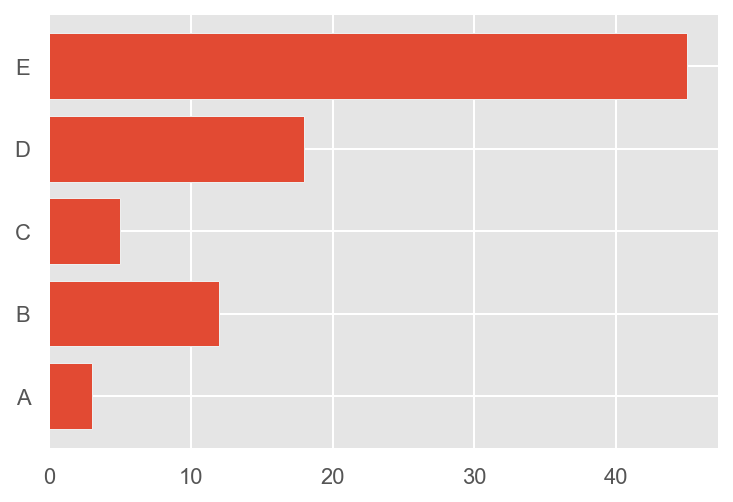

In [14]:
import numpy as np
import matplotlib.pyplot as plt
 
# Make fake dataset
height = [3, 12, 5, 18, 45]
bars = ('A', 'B', 'C', 'D', 'E')
y_pos = np.arange(len(bars))
 
# Create horizontal bars
plt.barh(y_pos, height)
 
# Create names on the y-axis
plt.yticks(y_pos, bars)
 
# Show graphic
plt.show()

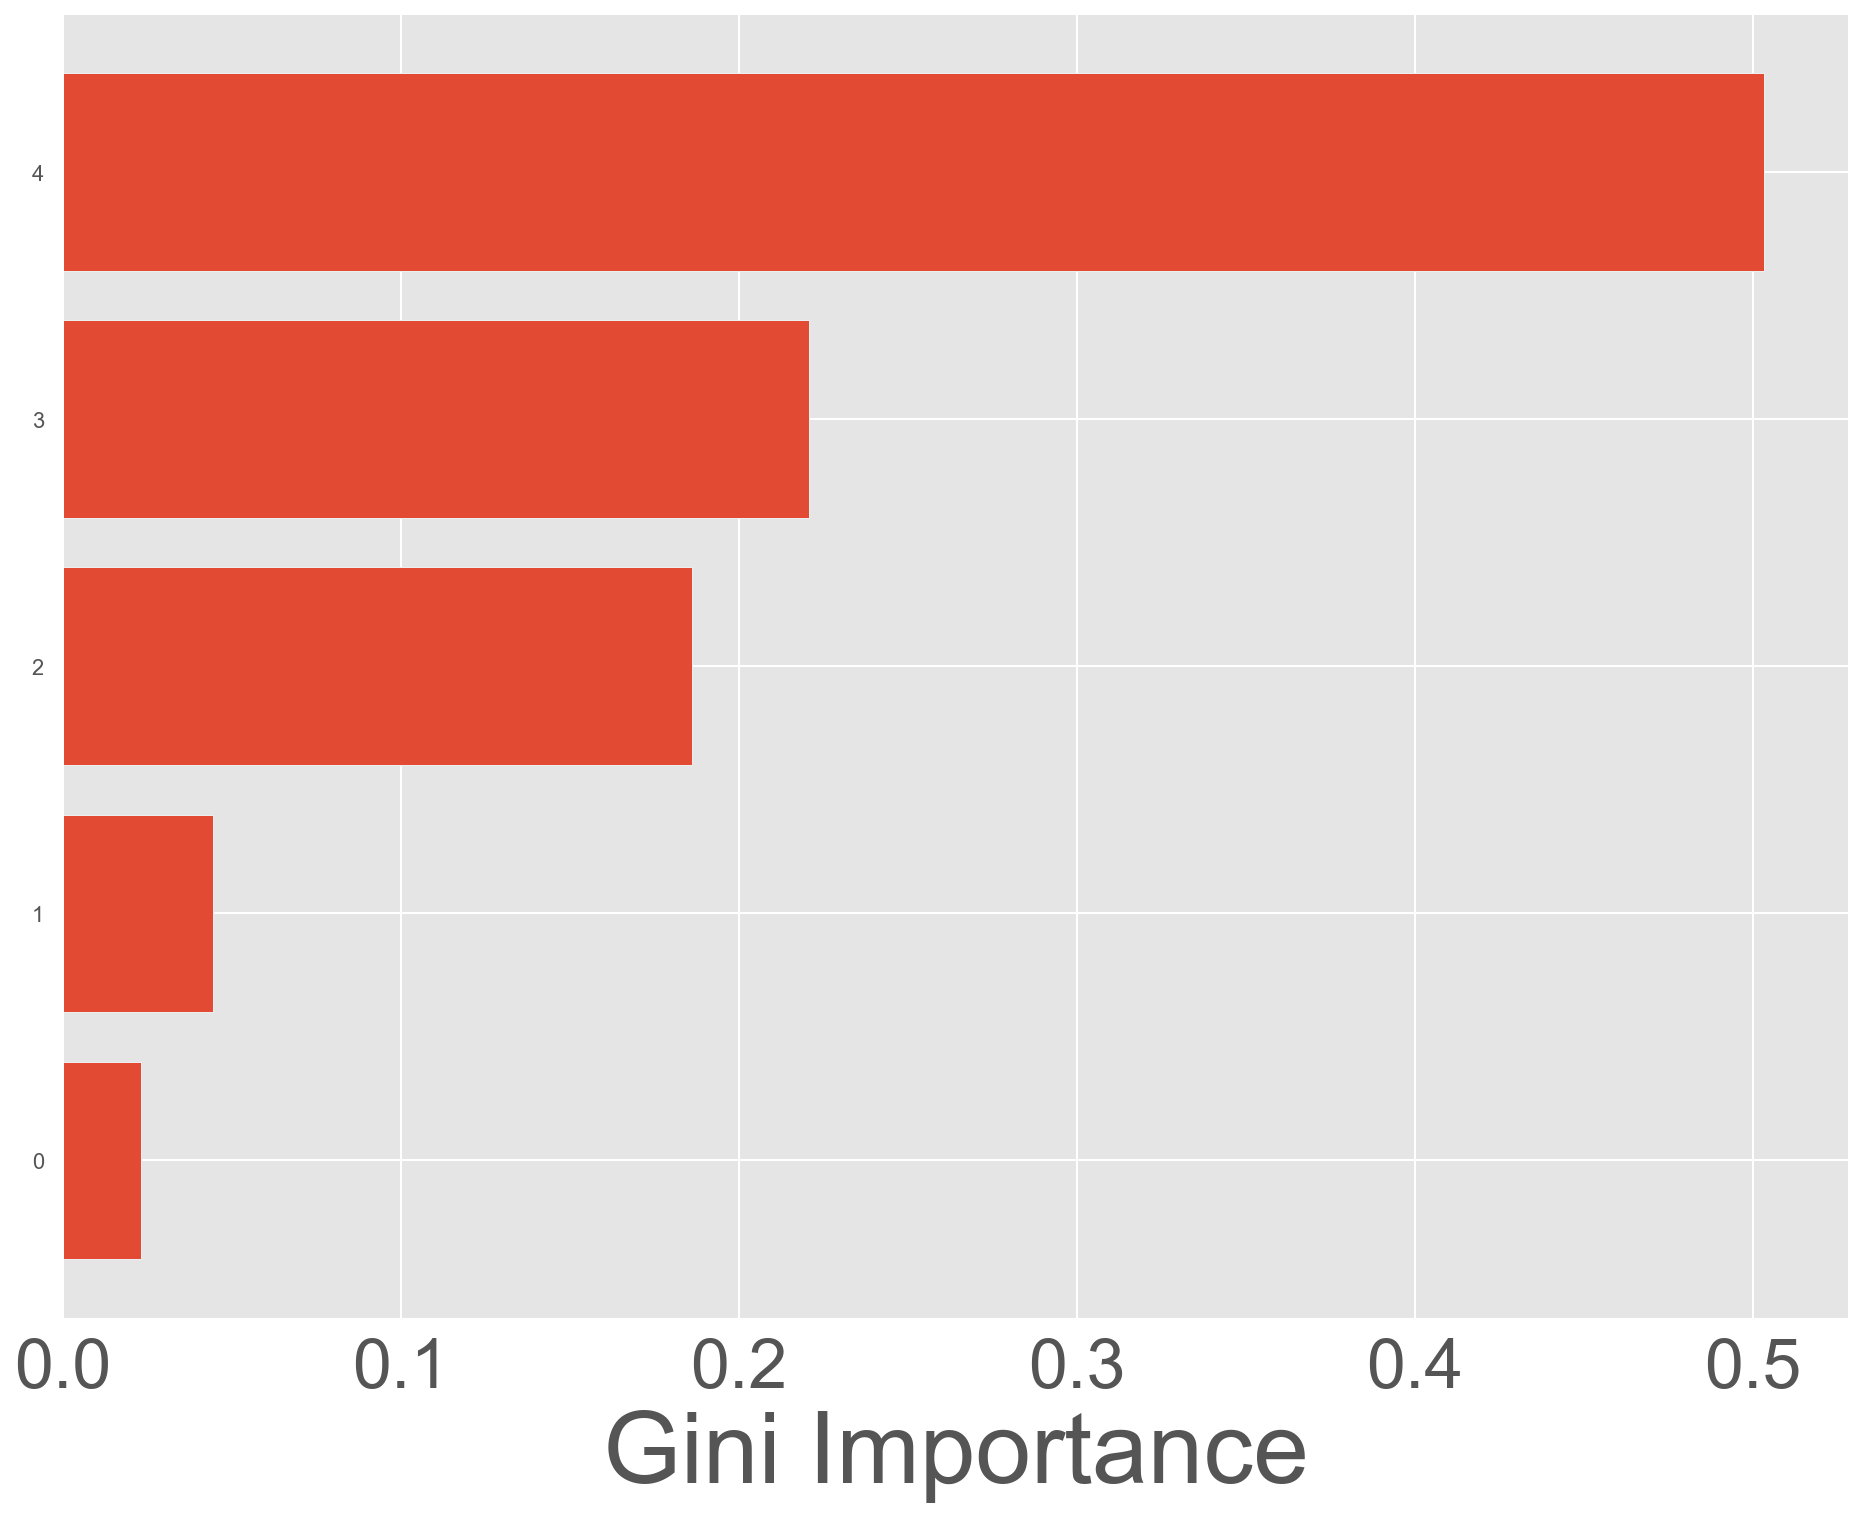

In [15]:
def plot_bar(rfr, feature_list):
    
    feature_importance = rfr.feature_importances_
    tmp = list(zip(feature_importance, feature_list))
    tmp = sorted(tmp,  key=lambda x: x[0], reverse=False)
    feature_importance, feature_list = list(zip(*tmp))

    # this is for plotting purpose
    index = np.arange(len(feature_list[6:]))
    plt.figure(figsize=(16, 12))
    plt.barh(index, feature_importance[6:])
    #plt.ylabel('Feature', fontsize=30)
    plt.xlabel('Gini Importance', fontsize=50)
    plt.xticks(fontsize=35)
    #plt.yticks(index, feature_list[6:], fontsize=15, rotation=30)
    #plt.title('Important features', fontsize=30)
    plt.show()
    
    
plot_bar(rfr, feature_list)

### Visualizing a Single Decision Tree

In [31]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rfr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')

# Support Vector Machines: Regression

## SVM Linear Kernel

In [16]:
def linear_svr_model(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=4444)
    
    gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    
    best_svr = SVR(kernel='linear', 
                   C=best_params["C"], 
                   epsilon=best_params["epsilon"], 
                   coef0=0.1, 
                   shrinking=True, 
                   tol=0.001, 
                   cache_size=200, 
                   verbose=False, 
                   max_iter=-1)

    best_svr.fit(X_train, y_train)
    
    scoring = {
               'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error'}

    scores = cross_validate(best_svr, X_test,y_test, cv=10, scoring=scoring, return_train_score=True)
    
    y_pred = cross_val_predict(best_svr, X_test, y_test, cv=10)
    
    r2 = r2_score(y_test, y_pred) 
    
    print("r^2 :", r2, "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean())) )
    return best_svr

# Run 
linear_svm = linear_svr_model(X,y)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

r^2 : 0.1986546703128187 MAE : 23.023896149297578 | RMSE : 38.767425091004945


/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
# Save the Model into pickle file
with open("./model/best_linear_svm.pkl" , 'wb') as file:
    pickle.dump(linear_svm, file)

# Load the Model back from file
with open('./model/best_linear_svm.pkl', 'rb') as file:  
    linear_svm  = pickle.load(file)


# Calculate the Score 
score = linear_svm.score(X_test, y_test) 

y_pred = linear_svm.predict(X_test)
score = r2_score(y_test, y_pred) 
# Print the Score
print("R2 score: {0:.2f} ".format(score))  

R2 score: 0.25 


## SVM Polynomila Kernel

In [22]:
def poly_svr_model(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=4444)
    
    gsc = GridSearchCV(
        estimator=SVR(kernel='poly'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'degree': [2, 3, 4],            
            'coef0': [0.1, 0.01, 0.001, 0.0001]},
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_svr = SVR(kernel='poly', 
                   C=best_params["C"], 
                   epsilon=best_params["epsilon"], 
                   coef0=best_params["coef0"],                   
                   degree=best_params["degree"], 
                   shrinking=True,
                   tol=0.001, 
                   cache_size=200, 
                   verbose=False, 
                   max_iter=-1)

    best_svr.fit(X_train, y_train)
    
    scoring = {
               'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error'}

    scores = cross_validate(best_svr, X_test, y_test, cv=10, scoring=scoring, return_train_score=True)
    
    y_pred = cross_val_predict(best_svr, X_test, y_test, cv=10)
    
    r2 = r2_score(y_test, y_pred) 
    
    print( "r^2 :", r2, "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean())) )
    
    return best_svr

# Run 
poly_svm = poly_svr_model(X,y)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The 

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The 

r^2 : 0.32639766881281385 MAE : 21.690765884771615 | RMSE : 35.54742089332253


In [26]:
# Save the Model into pickle file
with open("./model/best_poly_svm.pkl" , 'wb') as file:
    pickle.dump(poly_svm, file)

# Load the Model back from file
with open('./model/best_poly_svm.pkl', 'rb') as file:  
    poly_svm  = pickle.load(file)


# Calculate the Score 
score = poly_svm.score(X_test, y_test)  

y_pred = poly_svm.predict(X_test)
score = r2_score(y_test, y_pred) 
# Print the Score
print("R2 score: {0:.2f} ".format(score)) 

R2 score: 0.46 


## SVM RBF kernel

In [27]:
def rbf_svr_model(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=4444)
    
    gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
            'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    best_svr = SVR(kernel='rbf', 
                   C=best_params["C"], 
                   epsilon=best_params["epsilon"], 
                   gamma=best_params["gamma"],
                   coef0=0.1, 
                   shrinking=True,
                   tol=0.001, 
                   cache_size=200, 
                   verbose=False, 
                   max_iter=-1)

    best_svr.fit(X_train, y_train)
    
    scoring = {
               'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error'}

    scores = cross_validate(best_svr, X, y, cv=10, scoring=scoring, return_train_score=True)
    
    predictions = cross_val_predict(best_svr, X_test, y_test, cv=10)
    
    r2 = r2_score(y_test, predictions) 
    
    print("r^2 :", r2, "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean())) )

    return best_svr


# Run 
rbf_svm = rbf_svr_model(X,y)

/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWa

r^2 : -0.10056495239642538 MAE : 28.245238423298595 | RMSE : 46.794300016337786


/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ducvu/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed w

In [28]:
# Save the Model into pickle file
with open("./model/best_rbf_svm.pkl" , 'wb') as file:
    pickle.dump(rbf_svm, file)

# Load the Model back from file
with open('./model/best_rbf_svm.pkl', 'rb') as file:  
    rbf_svm  = pickle.load(file)


# Calculate the Score 
score = rbf_svm.score(X_test, y_test)  


y_pred = rbf_svm.predict(X_test)
score = r2_score(y_test, y_pred) 
# Print the Score
print("R2 score: {0:.2f} ".format(score)) 

R2 score: -0.05 


https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Prediction

In [ ]:
# Use datetime for creating date objects for plotting
import datetime

# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})



# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]


# Dataframe with predictions and dates
predictions = rfr.predict(y_test)
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')


# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()


# Graph labels
plt.xlabel('Date'); plt.ylabel('Outages'); plt.title('Actual and Predicted Outages');

https://github.com/igabr/Metis_Projects_Chicago_2017/blob/master/05-project-kojack/Final_Notebook.ipynb